## Imports

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import read
import pandas as pd
import math

def checkNotEmpty(input_array):
    for x in input_array:
        if float(x) > 0:
            return True
    return False

def getAverage(input_array):
    acc = 0.0
    for x in input_array:
        acc+=x
    return acc / len(input_array)

def getWindowFrameFromDir(source_dir, window_size):
    cache_windows = []
    ipc_windows = []
    for subdir, dirs, files in os.walk(source_dir):
        for dir in dirs:
            cache = []
            ipc = []
            ipc_window = []
            cache_window= []
            for filename in os.listdir(os.path.join(subdir, dir)):
                f = os.path.join(subdir, dir, filename)
                actualfile = open(f,'r')
                if (filename[:3] == "ipc"):
                    ipc = actualfile.readlines()
                else:
                    cache = actualfile.readlines()
            dipc = window_size-len(ipc)
            dcache = window_size-len(cache)
            if dipc > 0:
                for x in range(dipc):
                    ipc.append('0')
            if dcache > 0:
                for x in range(dcache):
                    cache.append('0')
            if (checkNotEmpty(cache) and checkNotEmpty(ipc)):
                for x in range(0, window_size):
                    ipc_window.append(float(ipc[x]))
                for x in range(0, window_size):
                    # let's normalize cache access to IPC
                    cache_window.append(float(cache[x])/1000000)
                cache_windows.append(getAverage(cache_window))
                ipc_windows.append(getAverage(ipc_window))
    dataframe = pd.DataFrame(list(zip(ipc_windows, cache_windows)), columns=['avg_ipc', 'avg_cache'])
    return dataframe
def create_reference(df, label):
    data = []
    for x in df.index:
        data.append(label)
    return data

def false_negative_rate(reference, prediction):
  false_negatives = 0
  true_positives = 0
  
  for i in range(len(reference)):
    if reference[i] == -1 and prediction[i] == 1:
      false_negatives += 1
    elif reference[i] == -1:
      true_positives += 1
      
  false_negative_rate = false_negatives / (false_negatives + true_positives)
  
  return false_negative_rate

def false_positive_rate(reference, prediction):
  false_positives = 0
  true_negatives = 0
  
  for i in range(len(reference)):
    if reference[i] == 1 and prediction[i] == -1:
      false_positives += 1
    elif reference[i] == 1:
      true_negatives += 1
      
  false_positive_rate = false_positives / (false_positives + true_negatives)
  
  return false_positive_rate


## Data frame construction

In [280]:
bench = "../results/benchmarks/" # change me if necessary
normal = "../results/custom_normal/"
attack = "../results/custom_attack/"
window_size = 10 # change me if necessary: 10 for custom, 50 for others

In [281]:
df_bench  = getWindowFrameFromDir(bench,window_size)
df_normal = getWindowFrameFromDir(normal,window_size)
df_bench


,avg_ipc,avg_cache
0,1.261,1.634147
1,1.790,1.002941
2,2.267,9.183417
3,0.644,4.697004
4,1.033,2.126906
...,...,...
1775,1.023,2.975180
1776,0.610,6.817950
1777,0.709,2.069494
1778,1.175,2.872858


<AxesSubplot: xlabel='avg_ipc', ylabel='Probability'>

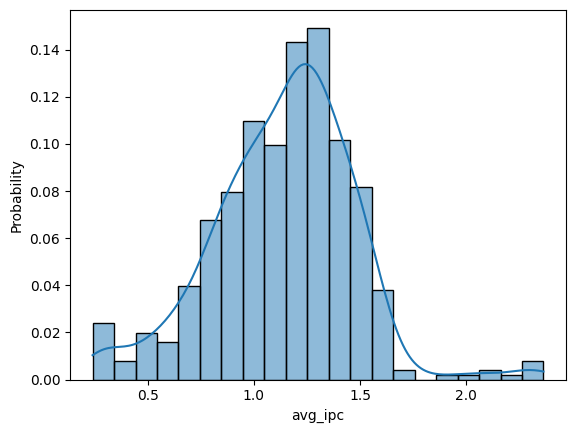

In [282]:
df_attack = getWindowFrameFromDir(attack,window_size)
import seaborn as sns
sns.histplot(df_attack['avg_ipc'], kde=True, stat='probability')

In [283]:
df_merged = pd.concat([df_normal, df_attack[:10]], ignore_index=True)
df_merged

,avg_ipc,avg_cache
0,0.337,0.295819
1,0.254,0.292299
2,0.254,0.288477
3,0.256,0.289798
4,0.343,0.291793
...,...,...
506,0.993,0.152264
507,1.167,0.153623
508,1.171,0.152835
509,1.560,0.152843


## Unsupervised stuff

### Categories visualization

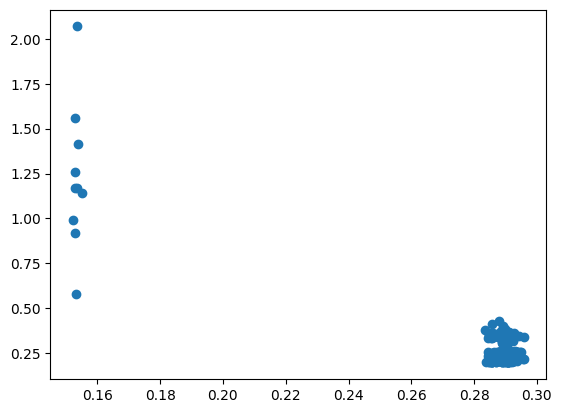

In [284]:
x_axis = df_merged["avg_ipc"]  
y_axis = df_merged["avg_cache"]  

# Plotting
plt.scatter(y_axis, x_axis)
plt.show()

### K-means (2)

/home/jef/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


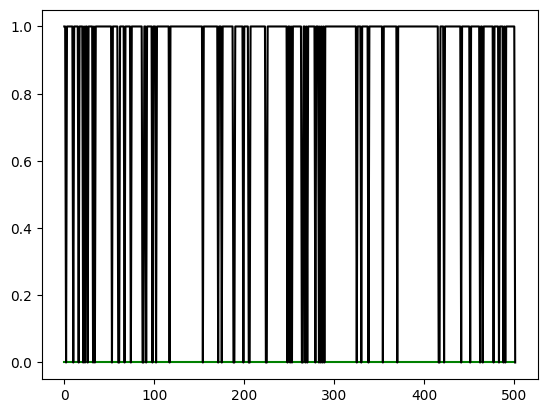

In [285]:
from sklearn import datasets
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)

# Fitting Model
model.fit(df_merged)

# Predicting using the whole dataset
whole_prediction = model.predict(df_merged)
attack_prediction = model.predict(df_attack)
normal_prediction = model.predict(df_normal)
bench_prediction = model.predict(df_bench)


plt.plot(normal_prediction, c='green')
plt.plot(attack_prediction, c='black')

### One-class SVM

[Full set] fp =  5.99 % fn =  0.0 %


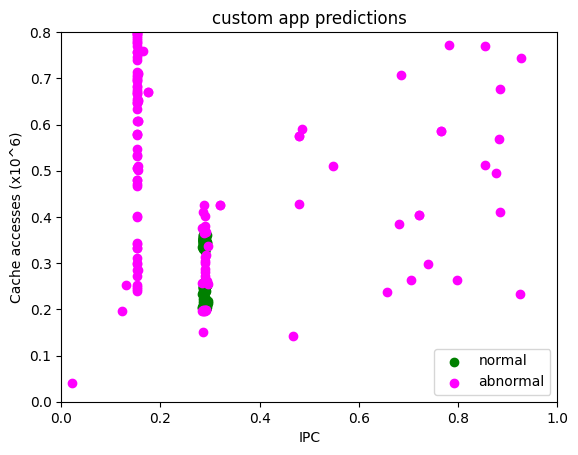

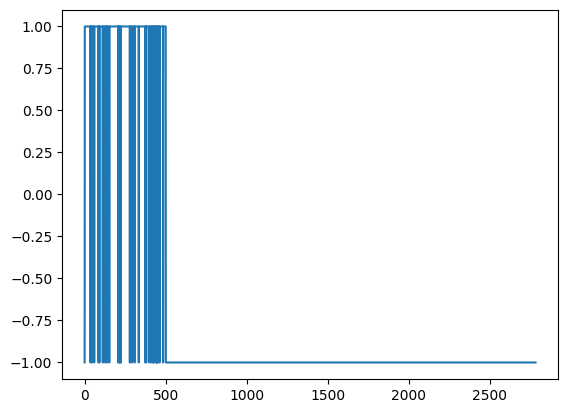

In [286]:
from sklearn import datasets
from sklearn import svm
from sklearn.svm import OneClassSVM

X_train = df_normal


clf = OneClassSVM(gamma='scale', kernel='rbf', nu=0.06).fit(X_train) #0.07
#TODO: explore nu value https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM.decision_function
Y_pred_attack = clf.predict(df_attack)
Y_pred_normal = clf.predict(df_normal)
Y_pred_bench = clf.predict(df_bench)

y_train_normal = create_reference(df_normal, 1)
y_train_attack = create_reference(df_attack, -1)
y_train_bench = create_reference(df_bench, -1)


y_train = np.concatenate([y_train_normal, y_train_attack, y_train_bench])
y_pred = np.concatenate([Y_pred_normal, Y_pred_attack, Y_pred_bench])
df_merged =  pd.concat([df_normal, df_attack, df_bench], ignore_index=True)
x_axis = df_merged["avg_ipc"]  
y_axis = df_merged["avg_cache"]  

x_norm, x_anorm, y_norm, y_anorm = [], [], [], []
for i in range (len(y_pred)):
    if y_pred[i] == 1:
        x_norm.append(x_axis[i])
        y_norm.append(y_axis[i])
    else:
        x_anorm.append(x_axis[i])
        y_anorm.append(y_axis[i])

print("[Full set] fp = ", round(false_positive_rate(y_train, y_pred)*100,2), "% fn = ", round(false_negative_rate(y_train, y_pred)*100,2), "%")

# # Plotting
c1 = plt.scatter(y_norm, x_norm, c='green')
c2 = plt.scatter(y_anorm, x_anorm, c='magenta')
plt.legend([c1, c2], ['normal', 'abnormal'])
plt.xlim(0,1) #nolimit for tinyexr
plt.ylim(0,0.8) #2.5 for tinyexr, 1 for pcf2bdf
plt.xlabel("IPC")
plt.ylabel("Cache accesses (x10^6)")
plt.title("custom app predictions")
plt.show()


plt.plot(y_pred)